# Job recommendation engine


* Which country, state and city are popular among job creator?
* Which country, state and city are popular among job seekers?
* Recommend similar jobs based on the jobs title, description
* Recommend jobs based on similar user profiles

## Import dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load dataset

In [3]:
wd = '/content/drive/MyDrive/NAM4/KhaiPhaDuLieu/input_data/'

In [4]:
apps = pd.read_csv(wd + 'apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv(wd + 'user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv(wd + 'jobs.tsv', delimiter='\t',encoding='utf-8', on_bad_lines='skip')
users = pd.read_csv(wd + 'users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv(wd + 'test_users.tsv', delimiter='\t',encoding='utf-8')

In [6]:
apps.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [ ]:
apps.columns

Index(['UserID', 'WindowID', 'Split', 'ApplicationDate', 'JobID'], dtype='object')

In [ ]:
apps.shape

(1603111, 5)

In [ ]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603111 entries, 0 to 1603110
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   UserID           1603111 non-null  int64 
 1   WindowID         1603111 non-null  int64 
 2   Split            1603111 non-null  object
 3   ApplicationDate  1603111 non-null  object
 4   JobID            1603111 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 61.2+ MB


In [ ]:
user_history.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [ ]:
user_history.columns

Index(['UserID', 'WindowID', 'Split', 'Sequence', 'JobTitle'], dtype='object')

In [ ]:
user_history.shape

(1753901, 5)

In [ ]:
user_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753901 entries, 0 to 1753900
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   UserID    int64 
 1   WindowID  int64 
 2   Split     object
 3   Sequence  int64 
 4   JobTitle  object
dtypes: int64(3), object(2)
memory usage: 66.9+ MB


In [7]:
jobs.head(10)

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59
5,10,1,SALON/SPA COORDINATOR,<b> <b>— SALON/SPA COORDINATOR ...,Please refer to the Job Description to view th...,Ormond Beach,FL,US,32174,2012-03-05 14:21:50.203,2012-04-04 23:59:59
6,11,1,SUPERINTENDENT,<b> <b>SUPERINTENDENT</b> </b> —— Central...,Please refer to the Job Description to view th...,Orlando,FL,US,32801,2012-03-06 09:21:54.58,2012-04-05 23:59:59
7,12,1,ELECTRONIC PRE-PRESS PROFESSIONAL,<b> <b>ELECTRONIC PRE-PRESS PROFESSIONAL</b...,Please refer to the Job Description to view th...,Orlando,FL,US,32808,2012-03-06 11:21:53.63,2012-04-05 23:59:59
8,13,1,UTILITY LINE TRUCK OPERATOR/ DIGGER DERRICK,<b> </b> \r\n <b> <b>UTILITY LINE TRUCK...,Please refer to the Job Description to view th...,Orlando,FL,US,32801,2012-03-06 16:06:53.677,2012-04-05 23:59:59
9,14,1,CONSTRUCTION PROJECT MGR & PM TRAINEE,<b> <b>CONSTRUCTION PROJECT MGR </b> </b> \...,Please refer to the Job Description to view th...,Winter Park,FL,US,32789,2012-03-07 10:21:37.467,2012-04-06 23:59:59


In [ ]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [ ]:
jobs.shape

(1091923, 11)

In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091923 entries, 0 to 1091922
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   JobID         1091923 non-null  int64 
 1   WindowID      1091923 non-null  int64 
 2   Title         1091916 non-null  object
 3   Description   1091706 non-null  object
 4   Requirements  1050478 non-null  object
 5   City          1091921 non-null  object
 6   State         1091922 non-null  object
 7   Country       1091920 non-null  object
 8   Zip5          685724 non-null   object
 9   StartDate     1091923 non-null  object
 10  EndDate       1091914 non-null  object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


In [ ]:
users.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
users.columns

Index(['UserID', 'WindowID', 'Split', 'City', 'State', 'Country', 'ZipCode',
       'DegreeType', 'Major', 'GraduationDate', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany'],
      dtype='object')

In [ ]:
users.shape

(389708, 15)

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389708 entries, 0 to 389707
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   UserID                389708 non-null  int64  
 1   WindowID              389708 non-null  int64  
 2   Split                 389708 non-null  object 
 3   City                  389708 non-null  object 
 4   State                 389218 non-null  object 
 5   Country               389708 non-null  object 
 6   ZipCode               387974 non-null  object 
 7   DegreeType            289555 non-null  object 
 8   Major                 292405 non-null  object 
 9   GraduationDate        269477 non-null  object 
 10  WorkHistoryCount      389708 non-null  int64  
 11  TotalYearsExperience  375528 non-null  float64
 12  CurrentlyEmployed     347632 non-null  object 
 13  ManagedOthers         389708 non-null  object 
 14  ManagedHowMany        389708 non-null  int64  
dtype

In [ ]:
test_users.head()

,UserID,WindowID
0,767,1
1,769,1
2,861,1
3,1006,1
4,1192,1


In [ ]:
test_users.columns

Index(['UserID', 'WindowID'], dtype='object')

In [ ]:
test_users.shape

(22838, 2)

In [ ]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   UserID    22838 non-null  int64
 1   WindowID  22838 non-null  int64
dtypes: int64(2)
memory usage: 357.0 KB


## Exploratory Data Analysis (EDA) and Pre-processing

### Split training and testing data based on column `split`

* Here, there are three datafiles/dataframes are having attribute split.
    * apps
    * user_history
    * users
* This data attribute indicates that whether the data record can be used for training or testing so we need to filter out based on that.
* We are generating training and testing dataframes


In [ ]:
apps_training = apps.loc[apps['Split'] == 'Train']

* Lọc các dòng trong DataFrame apps mà giá trị của cột 'Split' là 'Train'.

In [ ]:
apps_training.shape

(1417514, 5)

In [ ]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [ ]:
apps_testing = apps.loc[apps['Split'] == 'Test']

* Lọc các dòng trong apps mà giá trị của cột Split là 'Test'

In [ ]:
apps_testing.shape

(185597, 5)

In [ ]:
apps_testing.head()

,UserID,WindowID,Split,ApplicationDate,JobID
126,767,1,Test,2012-04-01 14:37:20.023,85377
127,769,1,Test,2012-04-16 22:36:52.48,853328
128,769,1,Test,2012-04-09 18:59:28.193,86106
129,769,1,Test,2012-04-09 18:59:31.127,327571
130,769,1,Test,2012-04-08 21:29:11.993,119161


In [ ]:
user_history_training = user_history.loc[user_history['Split'] =='Train']

In [ ]:
user_history_training = user_history.loc[user_history['Split'] =='Train']
user_history_testing = user_history.loc[user_history['Split'] =='Test']
apps_training = apps.loc[apps['Split'] == 'Train']
apps_testing = apps.loc[apps['Split'] == 'Test']
users_training = users.loc[users['Split']=='Train']
users_testing = users.loc[users['Split']=='Test']

In [ ]:
user_history_training.shape

(1652513, 5)

In [ ]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [ ]:
user_history_testing = user_history.loc[user_history['Split'] =='Test']

In [ ]:
user_history_testing.shape

(101388, 5)

In [ ]:
user_history_testing.head()

,UserID,WindowID,Split,Sequence,JobTitle
144,767,1,Test,1,Claims Adjuster
145,767,1,Test,2,Professional Baseball Player
146,767,1,Test,3,Professional Baseball Player
147,767,1,Test,4,Professional Baseball Player
148,767,1,Test,5,Professional Baseball Player


In [ ]:
users_training = users.loc[users['Split']=='Train']

In [ ]:
users_training.shape

(366870, 15)

In [ ]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
users_testing = users.loc[users['Split']=='Test']

In [ ]:
users_testing.shape

(22838, 15)

In [ ]:
users_testing.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
31,767,1,Test,Murrieta,CA,US,92562,Bachelor's,University Studies/Business,2008-05-01 00:00:00,5,16.0,No,No,0
32,769,1,Test,Roselle,IL,US,60172,Bachelor's,Radio-Television,2011-05-01 00:00:00,5,5.0,Yes,No,0
33,861,1,Test,Morris,IL,US,60450,High School,General Studies,1989-05-01 00:00:00,7,21.0,NaN,No,0
38,1006,1,Test,West Chester,PA,US,19382,High School,Not Applicable,2008-06-01 00:00:00,3,6.0,Yes,No,0
44,1192,1,Test,Cincinnati,OH,US,45255,Bachelor's,Marketing,NaN,5,6.0,Yes,No,0


### List down all training data records

In [ ]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [ ]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [ ]:
users_training.head(5).transpose()

,0,1,2,3,4
UserID,47,72,80,98,123
WindowID,1,1,1,1,1
Split,Train,Train,Train,Train,Train
City,Paramount,La Mesa,Williamstown,Astoria,Baton Rouge
State,CA,CA,NJ,NY,LA
Country,US,US,US,US,US
ZipCode,90723,91941,08094,11105,70808
DegreeType,High School,Master's,High School,Master's,Bachelor's
Major,NaN,Anthropology,Not Applicable,Journalism,Agricultural Business
GraduationDate,1999-06-01 00:00:00,2011-01-01 00:00:00,1985-06-01 00:00:00,2007-05-01 00:00:00,2011-05-01 00:00:00


In [ ]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


### EDA for job openings based on their location information

In [ ]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

,City,State,Country,Locationwise
0,&#60;&#47;b&#62; Brno &#60;b&#62;,,CZ,1
1,&#60;&#47;b&#62; Praha &#60;b&#62;,,CZ,1
2,- Any,,CZ,13
3,29 Palms,CA,US,1
4,<,,HU,1
...,...,...,...,...
15689,puebla,,MX,1
15690,san jose,,BJ,6
15691,san jose,,UA,1
15692,seoul,,KR,2


* Here note that for data attribute state, there are some blank/empty values are present.
* We will take care of it very soon

In [ ]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


In [5]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False)

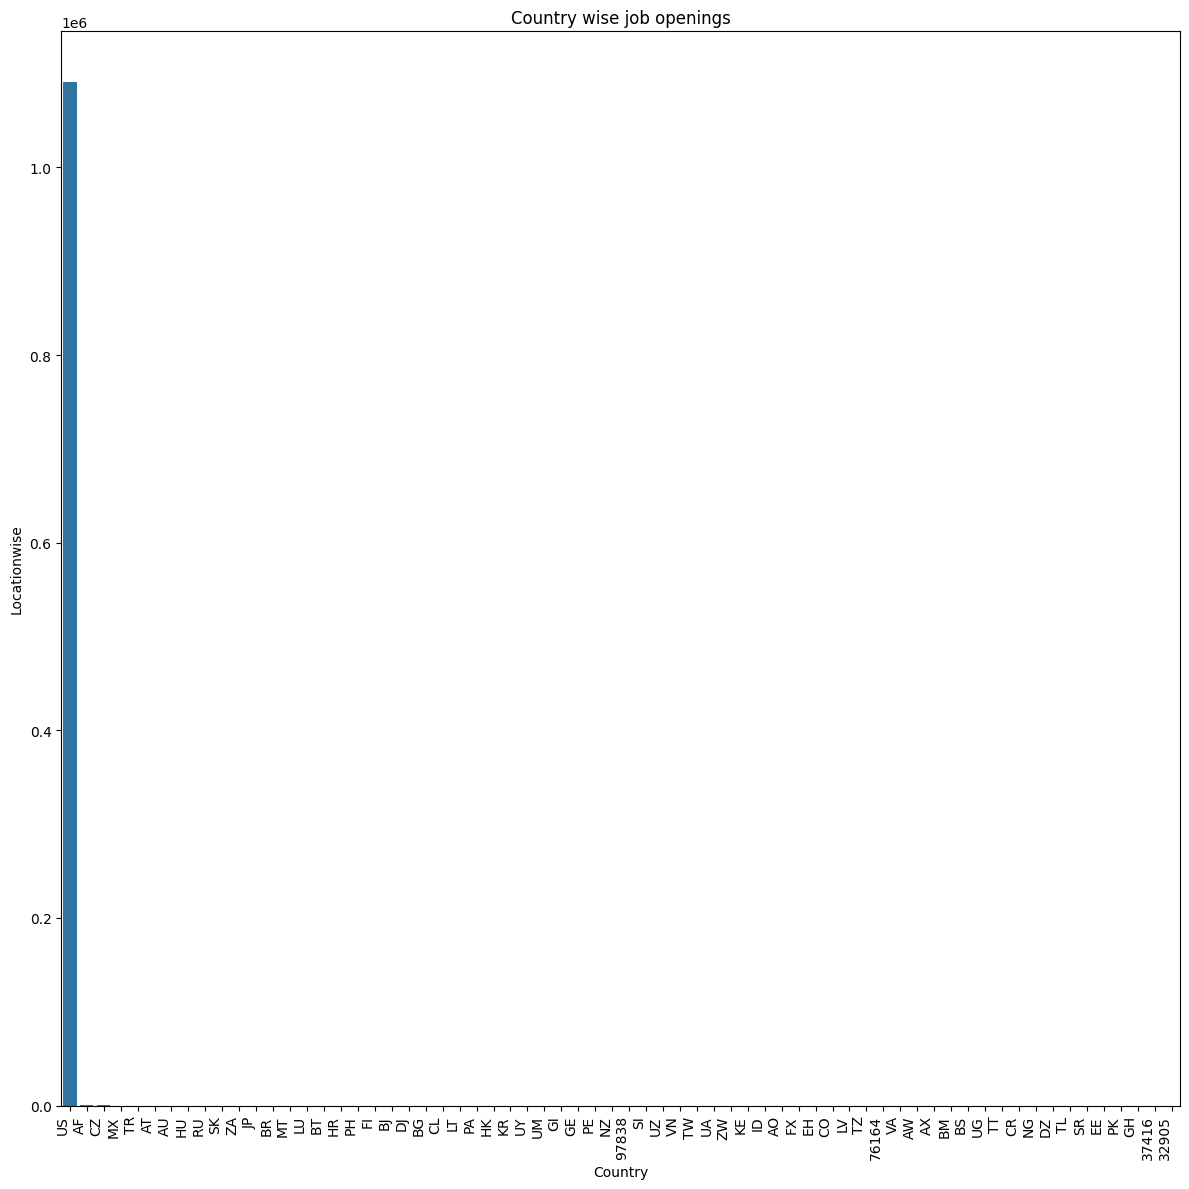

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

### pre-processing

* Now we will perform following pre-processing steps:
  * We will consider only US region for building this recommendation engine
  * We will be removing data records where state is blank or state data attribute is having numerical value.(If needed)

In [6]:
jobs_US = jobs.loc[jobs['Country']=='US']

In [7]:
jobs_US[['City','State','Country']]

,City,State,Country
0,Washington,DC,US
1,Charlotte,NC,US
2,Winter Park,FL,US
3,Orlando,FL,US
4,Orlando,FL,US
...,...,...,...
1091918,Amsterdam,NY,US
1091919,Birmingham,AL,US
1091920,Carthage,MS,US
1091921,Warren,MI,US


In [10]:
jobs_US.groupby(['City','State','Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,City,State,Country,Locationwise
6601,Houston,TX,US,19306
9835,New York,NY,US,18395
2651,Chicago,IL,US,17806
3475,Dallas,TX,US,13139
610,Atlanta,GA,US,12352


In [8]:
State_wise_job_US = jobs_US.groupby(['State']).size().reset_index(name=
                                                                       'Locationwise'
                                                                      ).sort_values('Locationwise',ascending=False)

In [9]:
State_wise_job_US

,State,Locationwise
5,CA,109630
48,TX,98071
10,FL,71024
16,IL,58743
38,NY,53998
42,PA,48999
39,OH,45048
34,NJ,35175
30,NC,34553
11,GA,33453


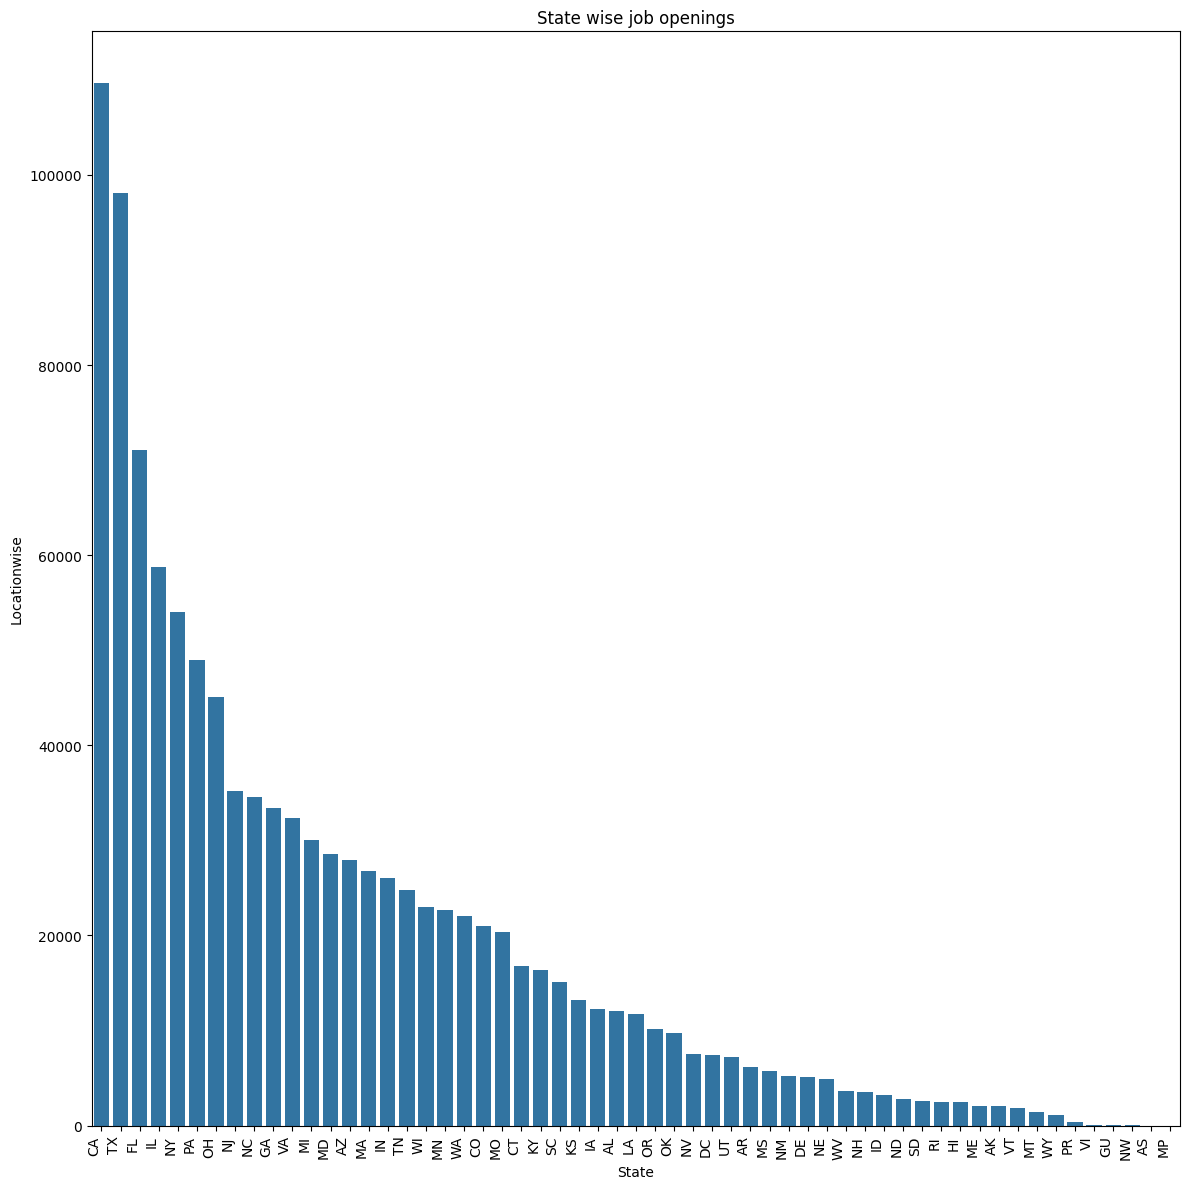

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise",data=State_wise_job_US)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

In [10]:
jobs_US.groupby(['City']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
2293,Cuchillo,1
7652,Picabo,1
2290,Crystola,1
2286,Crystal Hill,1


In [11]:
City_wise_location = jobs_US.groupby(['City']).size().reset_index(
    name='Locationwise').sort_values('Locationwise',ascending=False)

In [12]:
City_wise_location_th = City_wise_location.loc[City_wise_location['Locationwise']>=12]

In [13]:
City_wise_location_th

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
6838,Newport Coast,12
4655,Ijamsville,12
2510,Denmark,12
9904,University Heights,12


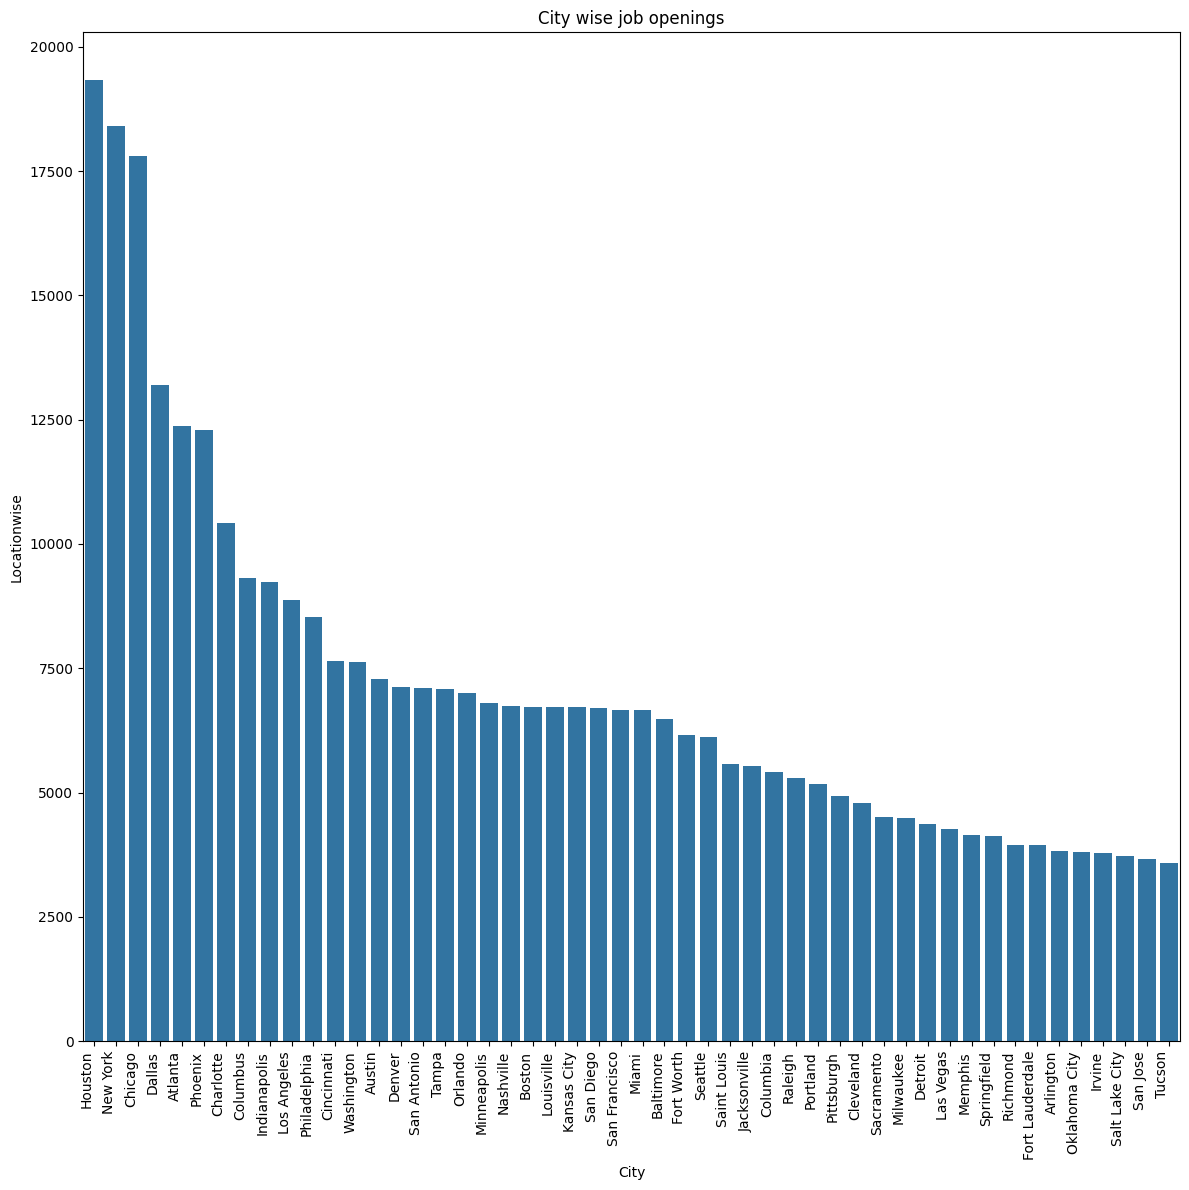

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise",data=City_wise_location_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()

#### Insights:

* When we do analysis state-wise then CA, TX, FL, IL and NY are having more job opening then other state
* When we do analysis city-wise then Houston, New York, Chicago, Dallas, Atlanta and Phoenix are having more jobs     compare to other cities

We have analyze the demand (job openings). Now there is time to analyze the supply(user-profiles)

### EDA for User profiles based on their location information

In [ ]:
users_training.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                                        ascending=False).head()

,Country,Locationwise
105,US,365740
47,IN,236
18,CA,108
81,PH,59
82,PK,59


In [ ]:
user_training_US = users_training.loc[users_training['Country']=='US']

In [ ]:
user_training_US.shape

(365740, 15)

In [ ]:
user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

,State,Locationwise_state
11,FL,40381
47,TX,33260
6,CA,31141
17,IL,22557
37,NY,19299
41,PA,16206
12,GA,15003
34,NJ,14887
38,OH,14750
30,NC,13887


In [ ]:
user_training_US_state_wise = user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

In [ ]:
user_training_US_th = user_training_US_state_wise.loc[user_training_US_state_wise['Locationwise_state']>=12]

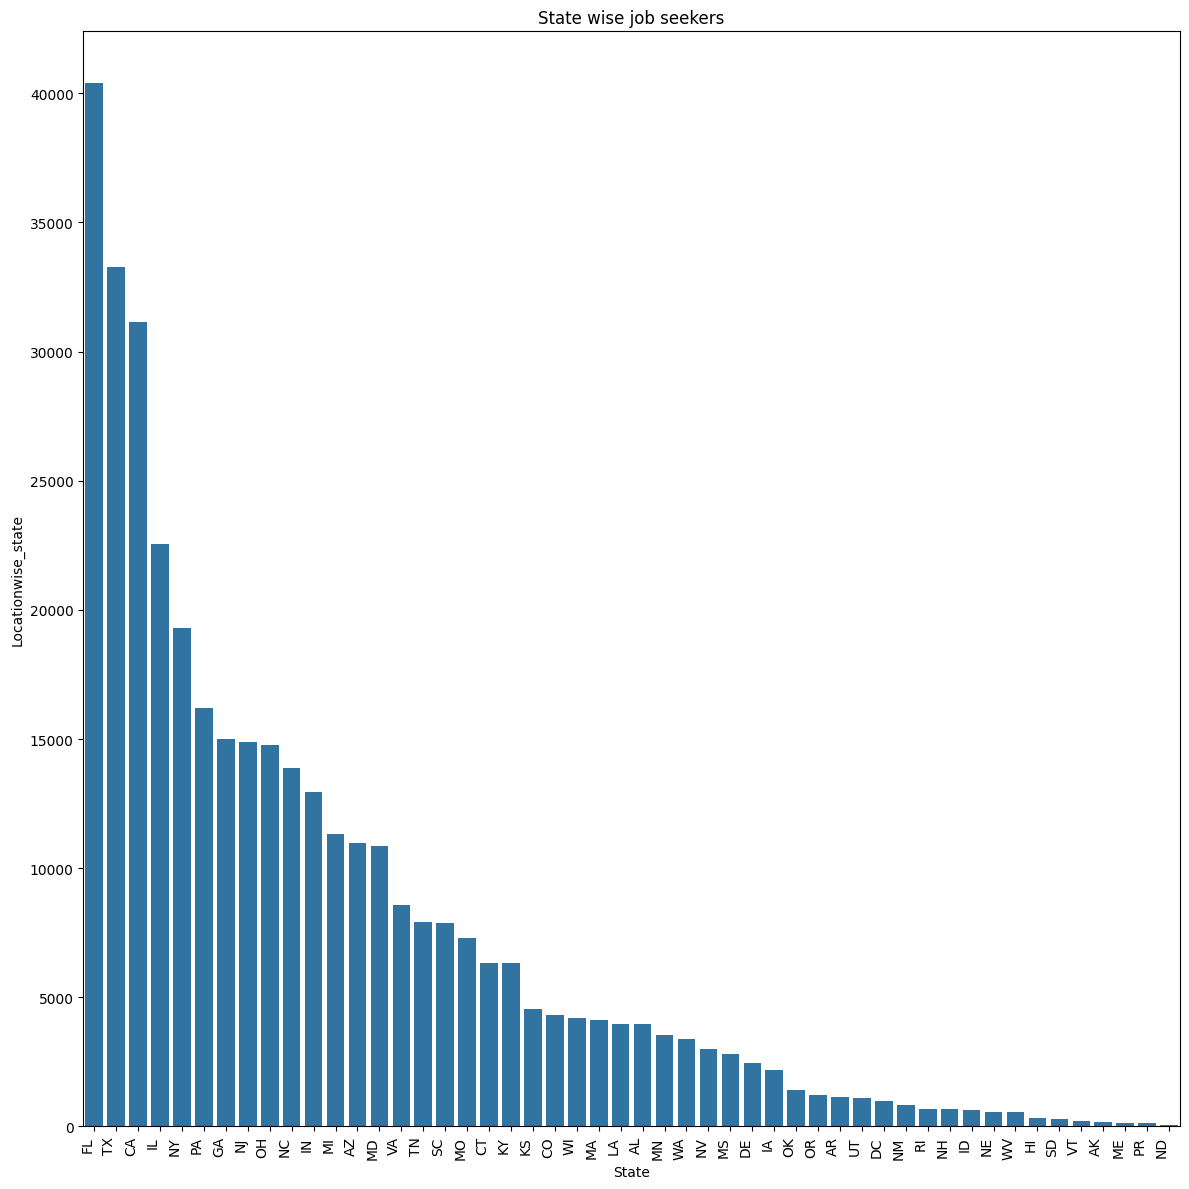

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise_state",data=user_training_US_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

In [ ]:
user_training_US.groupby(['City']).size().reset_index(
    name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

,City,Locationwise_city
1528,Chicago,6964
4066,Houston,5487
4177,Indianapolis,4450
5604,Miami,4359
6965,Philadelphia,4347
...,...,...
3046,Fort Pierre,1
3042,Fort Ogden,1
7369,Rancho Murieta,1
3032,Fort McCoy,1


In [ ]:
user_training_US_city_wise = user_training_US.groupby(['City']).size().reset_index(
    name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

In [ ]:
user_training_US_City_th = user_training_US_city_wise.loc[user_training_US_city_wise['Locationwise_city']>=12]

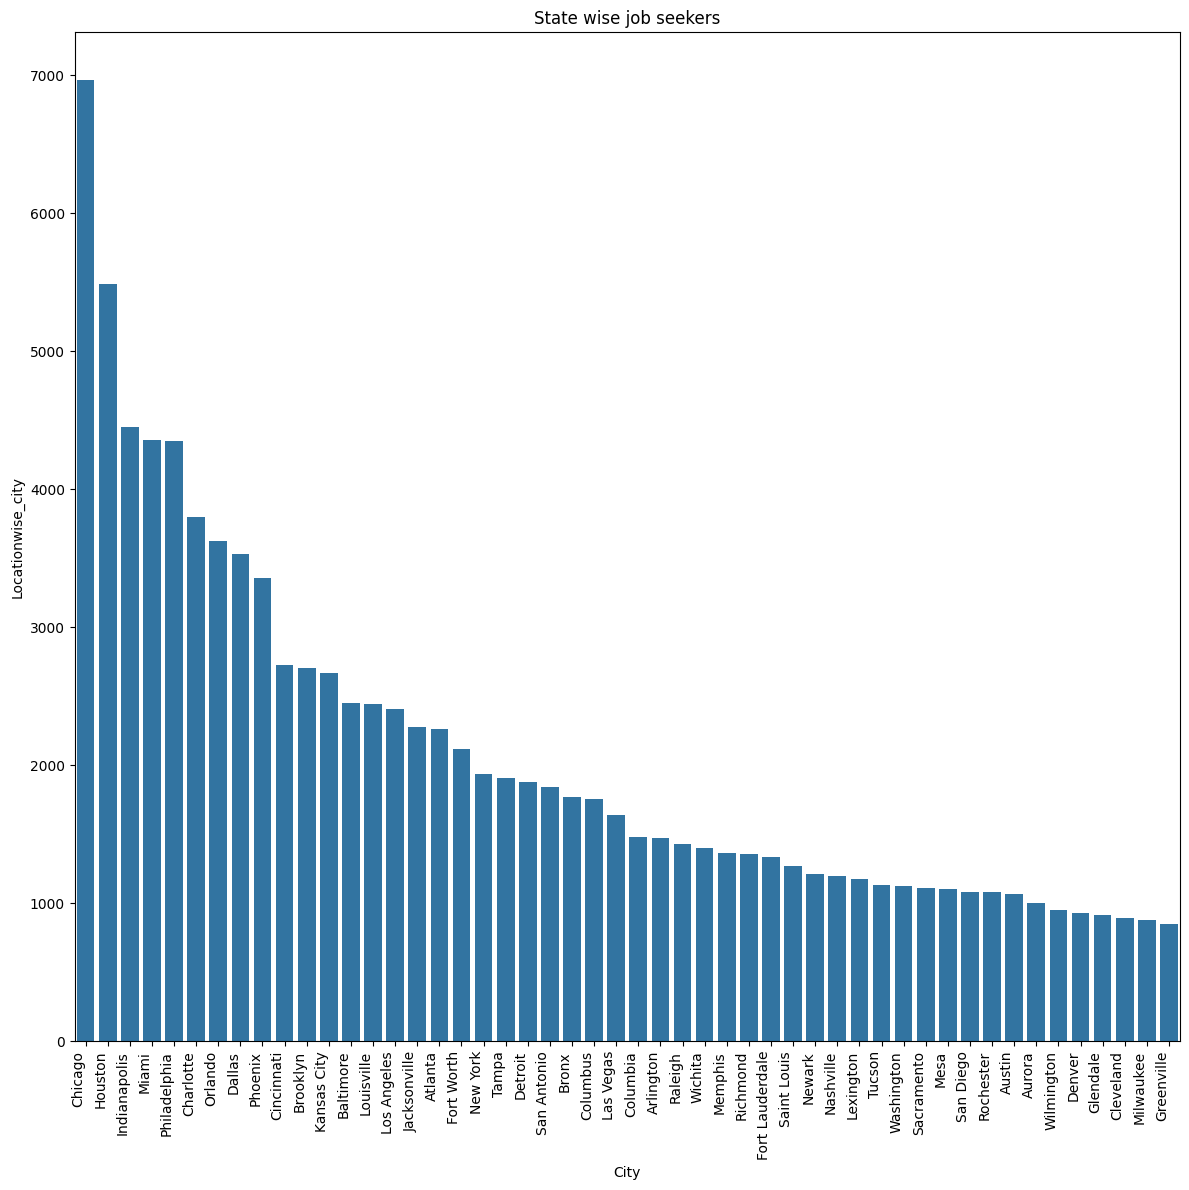

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise_city",data=user_training_US_City_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

* Here note that we are going to consider the US region for our further analysis. We are not removing any
  data records right now.

* Up-till now we have obtain the popular state and city for job seeker and job creator

## revised approach


###  Let's find out Similar jobs

In [14]:
jobs_US.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [15]:
jobs_US.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [19]:
jobs_US.head().transpose()

,0,1,2,3,4
JobID,1,4,7,8,9
WindowID,1,1,1,1,1
Title,Security Engineer/Technical Lead,SAP Business Analyst / WM,P/T HUMAN RESOURCES ASSISTANT,Route Delivery Drivers,Housekeeping
Description,<p>Security Clearance Required:&nbsp; Top Secr...,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,CITY BEVERAGES Come to work for the best in th...,I make sure every part of their day is magica...
Requirements,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...
City,Washington,Charlotte,Winter Park,Orlando,Orlando
State,DC,NC,FL,FL,FL
Country,US,US,US,US,US
Zip5,20531,28217,32792,NaN,NaN
StartDate,2012-03-07 13:17:01.643,2012-03-21 02:03:44.137,2012-03-02 16:36:55.447,2012-03-03 09:01:10.077,2012-03-03 09:01:11.88


In [16]:
jobs_US_base_line = jobs_US.iloc[0:10000,0:8]

In [17]:
jobs_US_base_line.drop_duplicates(inplace=True)

In [22]:
jobs_US_base_line.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US


In [18]:
missing_values = jobs_US_base_line.isnull().sum()
missing_values

JobID             0
WindowID          0
Title             0
Description       0
Requirements    169
City              0
State             0
Country           0
dtype: int64

In [19]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
jobs_US_base_line['Requirements'] = jobs_US_base_line['Requirements'].fillna('')

In [20]:
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Tải về dữ liệu cần thiết cho NLTK
nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def clean_text(text):
    # Loại bỏ các ký tự không phải là chữ cái hoặc số
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tách từ và chuyển đổi về chữ thường
    tokens = nltk.word_tokenize(text.lower())

    # Loại bỏ từ dừng và thực hiện stemming
    stemming = [ps.stem(w) for w in tokens if w not in stop_words]

    return " ".join(stemming)


def clean_html(raw_html):
    # Sử dụng BeautifulSoup để xử lý HTML
    soup = BeautifulSoup(raw_html, "html.parser")

    # Loại bỏ tất cả các thẻ HTML
    clean_text = soup.get_text(separator=' ', strip=True)
    return clean_text

In [22]:
def clean_full_text(text):
    # Bước 1: Làm sạch HTML
    cleaned_html = clean_html(text)

    # Bước 2: Làm sạch văn bản
    clean_full_text = clean_text(cleaned_html)

    return clean_full_text

In [23]:
clean_html("<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...")

'SKILL SET Network Se...'

In [28]:
jobs_US_base_line['Job.Description'] = jobs_US_base_line['Description'].astype(str).apply(lambda x: clean_html(x))
jobs_US_base_line['Job.Requirements'] = jobs_US_base_line['Requirements'].astype(str).apply(lambda x: clean_html(x))
jobs_US_base_line['Job.Title'] = jobs_US_base_line['Title'].astype(str).apply(lambda x: clean_html(x))


In [29]:
jobs_US_base_line.head(5)

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Job.Description,Job.Requirements,Job.Title
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,Security Clearance Required: Top Secret \r Jo...,SKILL SET \r \r Network Security tools: \r \r ...,Security Engineer/Technical Lead
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,NO Corp. to Corp resumes are being considered ...,WHAT YOU NEED: \r Four year college degree \r ...,SAP Business Analyst / WM
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,P/T HUMAN RESOURCES ASSISTANT —— 1-2 years ex...,Please refer to the Job Description to view th...,P/T HUMAN RESOURCES ASSISTANT
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Route Delivery Drivers
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Housekeeping


In [30]:
jobs_US_base_line['Info'] = jobs_US_base_line['Job.Title'] + jobs_US_base_line['Job.Description']

In [31]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
#jobs_US_base_line['Requirements'] = jobs_US_base_line['Requirements'].fillna('')



In [53]:
jobs_US_base_line['Job.Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']



*   `fillna('')`: Thay thế các giá trị thiếu (NaN) trong các cột 'Title' và 'Description' bằng chuỗi rỗng ('').

* `jobs_US_base_line['Title'] + jobs_US_base_line['Description']`: Nối nội dung của cột 'Title' và 'Description' thành một chuỗi mới và gán lại cho cột 'Description'

In [41]:
jobs_US_base_line = jobs_US_base_line.reset_index()

In [42]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
# tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

* `analyzer='word'`: Sử dụng từ (word) làm đơn vị phân tích.
ngram_range=(1, 2): Tạo ra các n-gram từ 1 đến 2 từ (bao gồm cả unigram và bigram).
* `min_df=0`: Không bỏ qua bất kỳ từ nào dựa trên tần suất tài liệu (có thể điều chỉnh tùy theo nhu cầu, giá trị hợp lý thường là một số nguyên lớn hơn 0).
* `stop_words='english'`: Loại bỏ các từ dừng trong tiếng Anh (các từ phổ biến không mang nhiều ý nghĩa như "the", "is", "in", v.v.).
* `fit_transform(jobs_US_base_line['Description'])`: Điều chỉnh và chuyển đổi dữ liệu trong cột 'Description' của DataFrame jobs_US_base_line thành một ma trận TF-IDF.

In [43]:
# tfidf_matrix = tf.fit_transform(jobs_US_base_line['Job.Description'])
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Info'])

In [46]:
tfidf_matrix.shape

(10000, 524927)

In [47]:
# http://scikit-learn.org/stable/modules/metrics.html#linear-kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Đoạn mã trên sử dụng linear_kernel để tính toán độ tương đồng cosine giữa tất cả các cặp tài liệu trong ma trận TF-IDF tfidf_matrix.

In [48]:
cosine_sim

array([[1.        , 0.02963855, 0.00835881, ..., 0.01456124, 0.01456124,
        0.01456124],
       [0.02963855, 1.        , 0.00350609, ..., 0.02939507, 0.02939507,
        0.02939507],
       [0.00835881, 0.00350609, 1.        , ..., 0.01855457, 0.01855457,
        0.01855457],
       ...,
       [0.01456124, 0.02939507, 0.01855457, ..., 1.        , 1.        ,
        1.        ],
       [0.01456124, 0.02939507, 0.01855457, ..., 1.        , 1.        ,
        1.        ],
       [0.01456124, 0.02939507, 0.01855457, ..., 1.        , 1.        ,
        1.        ]])

In [49]:
similarity = cosine_similarity(tfidf_matrix)

In [50]:
similarity

array([[1.        , 0.02963855, 0.00835881, ..., 0.01456124, 0.01456124,
        0.01456124],
       [0.02963855, 1.        , 0.00350609, ..., 0.02939507, 0.02939507,
        0.02939507],
       [0.00835881, 0.00350609, 1.        , ..., 0.01855457, 0.01855457,
        0.01855457],
       ...,
       [0.01456124, 0.02939507, 0.01855457, ..., 1.        , 1.        ,
        1.        ],
       [0.01456124, 0.02939507, 0.01855457, ..., 1.        , 1.        ,
        1.        ],
       [0.01456124, 0.02939507, 0.01855457, ..., 1.        , 1.        ,
        1.        ]])

In [51]:
sorted(list(enumerate(cosine_sim[0])), key=lambda x: x[1], reverse=True)[1:20]

[(5906, 0.14203297149820757),
 (6380, 0.12469094694494981),
 (3248, 0.10640108227031134),
 (1302, 0.10402328275438201),
 (5525, 0.09974784984573062),
 (6873, 0.09178371403914144),
 (3230, 0.09039167429790819),
 (4901, 0.08848397801803541),
 (1568, 0.0875299410350316),
 (4692, 0.0837197182294944),
 (3125, 0.08035794988680181),
 (8928, 0.07923460914578442),
 (8929, 0.07923460914578442),
 (8930, 0.07923460914578442),
 (4693, 0.0732100085906561),
 (3224, 0.07068219495191178),
 (6070, 0.06985986909044917),
 (5465, 0.0696076196854697),
 (9297, 0.06826268343459767)]

In [52]:
sorted(list(enumerate(similarity[0])), key=lambda x: x[1], reverse=True)[1:20]

[(5906, 0.14203297149820748),
 (6380, 0.12469094694494984),
 (3248, 0.10640108227031135),
 (1302, 0.10402328275438201),
 (5525, 0.09974784984573065),
 (6873, 0.09178371403914139),
 (3230, 0.09039167429790816),
 (4901, 0.08848397801803541),
 (1568, 0.08752994103503159),
 (4692, 0.08371971822949434),
 (3125, 0.08035794988680181),
 (8928, 0.07923460914578448),
 (8929, 0.07923460914578448),
 (8930, 0.07923460914578448),
 (4693, 0.07321000859065613),
 (3224, 0.07068219495191178),
 (6070, 0.06985986909044918),
 (5465, 0.06960761968546968),
 (9297, 0.06826268343459772)]

In [57]:
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])
#indices.head(2)


In [62]:
indices

Title
Security Engineer/Technical Lead                                 0
SAP Business Analyst / WM                                        1
P/T HUMAN RESOURCES ASSISTANT                                    2
Route Delivery Drivers                                           3
Housekeeping                                                     4
                                                              ... 
Sales Representative / Account Manager /  Customer Service    9995
Sales Representative / Account Manager /  Customer Service    9996
Sales Representative / Account Manager /  Customer Service    9997
Sales Representative / Account Manager /  Customer Service    9998
Sales Representative / Account Manager /  Customer Service    9999
Length: 10000, dtype: int64

In [53]:
jobs_US_base_line.columns

Index(['index', 'JobID', 'WindowID', 'Title', 'Description', 'Requirements',
       'City', 'State', 'Country', 'Job.Description', 'Job.Requirements',
       'Job.Title', 'Info'],
      dtype='object')

In [58]:
def get_recommendations(title):
    idx = indices[title]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return titles.iloc[job_indices]

In [67]:
columns_to_select = ['index', 'JobID', 'WindowID', 'Job.Title', 'Description', 'Requirements', 'City', 'State', 'Country']
output_job = jobs_US_base_line[columns_to_select]

In [74]:
jobs_US_base_line.columns

Index(['level_0', 'index', 'JobID', 'WindowID', 'Title', 'Description',
       'Requirements', 'City', 'State', 'Country', 'Job.Description',
       'Job.Requirements', 'Job.Title', 'Info'],
      dtype='object')

In [70]:
import pickle

In [73]:
pickle.dump(jobs_US_base_line,open(wd + 'df.pkl','wb'))

In [ ]:
# pickle.dump(similarity,open('similarity.pkl','wb'))
pickle.dump(cosine_sim,open(wd + 'similarity.pkl','wb'))

In [59]:
get_recommendations('SAP Business Analyst / WM').head(10)

1                           SAP Business Analyst / WM
6051                    SAP FI/CO Business Consultant
5868                       SAP FI/CO Business Analyst
5159                          SAP Basis Administrator
5351    SAP Sales and Distribution Solution Architect
4796       Senior Specialist - SAP Configuration - SD
4290           SAP FICO Functional -2years experience
5117                       SAP Integration Specialist
5244                                 Business Analyst
4728           SAP ABAP Developer with PRA experience
Name: Title, dtype: object

In [60]:
get_recommendations('Security Engineer/Technical Lead').head(10)

0                        Security Engineer/Technical Lead
5906                             Senior Security Engineer
6380                Security Technology - SIEM Consultant
3248                Senior Lead Systems Security Engineer
1302                       Information Security Architect
5525                   Sr. Information Security Architect
6873              Integrated System Service Engineer - CA
3230                    Computer Systems Security Manager
4901    Cloud Services Security Application Administrator
1568                 Senior Information Security Engineer
Name: Title, dtype: object

In [ ]:
get_recommendations('Immediate Opening').head(10)

13                           Immediate Opening
216                      Accounting/Bookkeeper
2872    Cable TV/Internet/Telephone Installers
8423                                    no job
4028                              Electricians
4029                              Electricians
4030                              Electricians
620                                     DENTAL
93                 A/C HEATING REFRIG MECHANIC
125                                   Optician
Name: Title, dtype: object

In [61]:
get_recommendations('P/T HUMAN RESOURCES ASSISTANT').head(10)

2                 P/T HUMAN RESOURCES ASSISTANT
6313    Human Resources Admin Support Assistant
39                Front Desk for Medical Office
7289                    Human Resources Manager
2786       Human Resources Specialist/Recruiter
2966              Human Resources Administrator
12                         COMMERCIAL ESTIMATOR
6943                  Human Resources Assistant
7465                  Human Resources Assistant
24                 CREDIT/COLLECTIONS ASSISTANT
Name: Title, dtype: object

## Best approach

#### Find out similar users -- Find out for which jobs they have applied -- suggest those job to the other users who shared similar user profile.

We are finding put similar user profile based on their degree type, majors and total years of experience.
* We will get to 10 similar users.
* We will find our which are the jobs for which these users have applied
* We take an union of these jobs and recommend the jobs all these user base

In [ ]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
user_based_approach_US = users_training.loc[users_training['Country']=='US']

In [ ]:
user_based_approach = user_based_approach_US.iloc[0:10000,:]

In [ ]:
user_based_approach.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = str(user_based_approach['TotalYearsExperience'].fillna(''))

user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + user_based_approach['Major'] + user_based_approach['TotalYearsExperience']


In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])

In [ ]:
tfidf_matrix.shape

(10000, 6865)

In [ ]:
# http://scikit-learn.org/stable/modules/metrics.html#linear-kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

array([1.        , 0.17876394, 0.39845967, ..., 0.08965938, 0.27428073,
       0.19371807])

In [ ]:
user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])
#indices.head(2)

In [ ]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return user_indices[0:11]

In [ ]:
print ("-----Top 10 Similar users with userId: 123------")
get_recommendations_userwise(123)


-----Top 10 Similar users with userId: 123------


[4, 150, 227, 988, 1362, 1364, 1573, 1625, 1793, 3882, 4283]

In [ ]:
def get_job_id(usrid_list):
    jobs_userwise = apps_training['UserID'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp

In [ ]:
get_job_id(get_recommendations_userwise(123))

,JobID,Title,Description,City,State
2855,11624,Field Technician,<P> </P>\r<P><B><SPAN>Field Technician </SPAN>...,Atlanta,GA
102266,400568,Sports and Entertainment Marketing - Entry Lev...,"<div>\r<div style=""text-align: center""><strong...",Atlanta,GA
106931,414442,Maintenance Technician,<B>Job Classification: </B> Contract \r\n\r\nA...,Zephyrhills,FL
108632,417018,I&C Technician,<B>Job Classification: </B> Contract \r\n\r\nR...,Tampa,FL
320689,254426,Human Resources Representative - 101,Our client is an Atlanta-based insurance compa...,Atlanta,GA
335534,362519,Now hiring!!,"<p style=""text-align: center"">Grand Opening<br...",Atlanta,GA
337835,381453,***IMMEDIATE HIRE*** ENTRY LEVEL OPENINGS-NO E...,"<p style=""text-align: center;""><strong><span>E...",Atlanta,GA
353391,491943,Atlanta Area Assistant Manager,Regional Management Company serching for Asst ...,Atlanta,GA
396537,803650,Clinical Nutrition Manager,"<p>AVI Foodsystems, Inc., America’s largest pr...",Mayfield Heights,OH
400668,833270,Patient Financial Counselor Atlanta Medical Ce...,<strong>Job: </strong> Conifer Health Solutio...,Atlanta,GA


In [ ]:
print ("-----Top 10 Similar users with userId: 47------")
get_recommendations_userwise(47)

-----Top 10 Similar users with userId: 47------


[0, 79, 126, 182, 345, 366, 393, 423, 434, 490, 544]

In [ ]:
get_job_id(get_recommendations_userwise(47))

,JobID,Title,Description,City,State
905894,428902,Aircraft Servicer,<b>Job Classification: </b> Direct Hire \r\n\r...,Memphis,TN
975525,1098447,Automotive Service Advisor,<div>\r<div>Briggs Nissan in Lawrence Kansas h...,Lawrence,KS
980507,37309,Medical Lab Technician - High Volume Lab,<span>Position Title:<span>&nbsp;&nbsp;&nbsp;&...,Fort Myers,FL
986244,83507,Nurse Tech (CNA/STNA),"<p align=""center""><b>Purpose of Your Job Posit...",Englewood,FL
987452,93883,Nurse Tech II (CNA/STNA),<B>Nurse Tech II (CNA/STNA)</B> <BR>\r<BR>\rTh...,Fort Myers,FL
1000910,228284,REGISTERED NURSE – ICU,"<p><strong><span><font face="""">Registered Nurs...",Punta Gorda,FL
1007140,284840,Certified Nursing Assistant / CNA,"<hr>\r<p style=""text-align: center""><strong>Ce...",Saint Petersburg,FL
1007141,284841,Home Health Aide / HHA,"<hr>\r<p style=""text-align: center""><strong>Ho...",Saint Petersburg,FL
1009455,312536,Secretary II,<br><br><b>Department: </b>COMM Maryland Cardi...,Baltimore,MD
1011978,341662,Medical Assistant,Certified Medical Assistant for busy Pain Clin...,Fort Myers,FL
